The goal of this notebook is to create a simple ML model that takes as input a pitch's velocity, movement, and maybe spin and release point, and a tunnel location and predicts the x and z location of that pitch at the plate. So I will run the trajectory model on the data to get actual tunnels, and then I'll be able to build the model.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
import math
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt

/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [ ]:
#read in data and calculate tunnels 
from google.colab import drive
drive.mount('/drive')

#read in the data
data = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_project/raw22.csv')

Mounted at /drive


In [ ]:
data.dropna(subset = ['release_extension', 
                      'release_speed','release_spin_rate', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'ax', 'ay', 'az',
                      'vx0', 'vy0', 'vz0', 'release_pos_x' ,'release_pos_z', 'pfx_x', 'pfx_z'], axis = 0,
            inplace = True)

In [ ]:
# pitch is the statcast dataframe of the pitch
# decision is the distance in feet from the plate that the decision point is. 

def trace_decision_trajectory(pitch, decision = 24):
  assert 60.5 >= decision >= 17/12
  #from statcast
  K = .005383
  dt = .001 # change in time. We originally had 0.001 which is way too slow
  circ = 9.125      # Circ of baseball
  tau = 10000
  v0 = pitch['release_speed'].values[0]
  x0 = pitch['release_pos_x'].values[0]
  y0 = 60.5 - pitch['release_extension'].values[0] # See documentation - changed to match calculations
  z0 = pitch['release_pos_z'].values[0]
  vx0 = pitch['vx0'].values[0]
  vy0 = pitch['vy0'].values[0]
  vz0 = pitch['vz0'].values[0]
  ay0 = pitch['ay'].values[0]
  ax0 = pitch['ax'].values[0]
  az0 = pitch['az'].values[0]

  pfx_x = pitch['pfx_x'].values[0]
  pfx_z = pitch['pfx_z'].values[0]
  plate_x = pitch['plate_x'].values[0]
  plate_z = pitch['plate_z'].values[0]


  release_spin = pitch['release_spin_rate'].values[0]
  spin_axis = pitch['spin_axis'].values[0]
  

  #calculated variables

  tR = (-1 * vy0 - math.sqrt(vy0 ** 2 -2 * ay0 * (50 - y0))) / ay0
  vxR = vx0 + ax0 * tR
  vyR = vy0 + ay0 * tR
  vzR = vz0 + az0 * tR
  dv0 = v0 - math.sqrt(vxR ** 2 + vyR ** 2 + vzR ** 2) / 1.467
  tf = (-1 * vyR - math.sqrt(vyR ** 2 - 2 * ay0 * (y0 - 17/12))) / ay0
  calculate_x_mvt = (plate_x - x0 - (vxR / vyR) * (17/12 - y0))
  calculate_z_mvt = (plate_z - z0 - (vzR / vyR) * (17/12 - y0)) + .5 * 32.174 * (tf ** 2)


  times = np.arange(0, tf + .2, dt, dtype=float)

  trajectory = pd.DataFrame(columns=['Time', 'X_Pos', 'Y_Pos','Z_Pos'])

  vxPrev = vxR
  vyPrev = vyR
  vzPrev = vzR

  axPrev = ax0 # Was ax bar
  ayPrev = ay0 # was ay bar
  azPrev = az0 # Was az bar

  xPrev = x0
  yPrev = y0
  zPrev = z0

  adrag = -(ax0 * vxR + ay0 * vyR + (az0 + 32.174) * vzR) / v0 
  Cd = adrag / (K * (v0 ** 2))

  adragx = -K * Cd * v0 * vx0
  adragy = -K * Cd * v0* vy0
  adragz = -K * Cd * v0 * vz0

  vxbar = (2 * vxR + ax0 * tf) / 2
  vybar = (2 * vyR + ay0 * tf) / 2
  vzbar = (2 * vzR + az0 * tf) / 2
  vbar = math.sqrt(vxbar ** 2 + vybar ** 2 + vzbar ** 2)
  adrag = -(ax0 * vxbar + ay0 * vybar + (az0 + 32.174) * vzbar) / vbar
  Cd = adrag / (K * vbar ** 2)


  amagx = ax0 + adrag * vxbar / vbar
  amagy = ay0 + adrag * vybar / vbar
  amagz = az0 + adrag * vzbar / vbar + 32.174
  amag = math.sqrt(amagx ** 2 + amagy ** 2 + amagz ** 2)

  Mx = .5 * amagx * tf ** 2 * 12
  Mz = .5 * amagz * tf ** 2 * 12
  Cl = amag / (K * vbar ** 2)
  S = .4 * Cl / (1-2.32 * Cl)
  spinT = 78.92 * S * vbar
  spinTX = spinT * (vybar * amagz - vzbar * amagy) / (amag * vbar)
  spinTY = spinT * (vzbar * amagx - vxbar * amagz) / (amag * vbar)
  spinTZ = spinT * (vxbar * amagy - vybar * amagx) / (amag * vbar)
  spin_check = math.sqrt(spinTX ** 2 + spinTY ** 2 + spinTZ ** 2) - spinT
  ax = amagx + adragx
  ay = amagy + adragy
  az = amagz + adragz - 32.174
  trajectory['Time'] = times
  location = trajectory['Time'] == times[0]
  trajectory.loc[location, 'X_Pos'] = xPrev
  trajectory.loc[location, 'Y_Pos'] = yPrev
  trajectory.loc[location, 'Z_Pos'] = zPrev


  reached_decision_point = False
  decision_x = None
  decision_z = None

  for time in times[1:]: # start at the second time interval because the first is base case and known




    v = math.sqrt((vxPrev ** 2) + (vyPrev ** 2) + (vzPrev ** 2))

    wperp = math.sqrt((spinT ** 2) - ((30 / math.pi) * (spinTX * vxR + spinTY * vyR + spinTZ * vzR) / v) ** 2) 
    romegaPerp = (wperp * math.pi / 30) * (circ / (2 * math.pi)) / 12 

    v_w = v # assuming no wind

    S = (romegaPerp / v_w) * math.exp(-time / (tau * 146.7 / v_w))
    



    # Calculate Current Ball Velocity Components Vx, Vy, Vz for next pass around

    vx = vxPrev + (axPrev * dt)
    vy = vyPrev + (ayPrev * dt)
    vz = vzPrev + (azPrev * dt)



    # Calculate Current Ball Position X,Y,Z
    xPrev = xPrev + (vxPrev * dt) + (.5 * (axPrev) * (dt ** 2))
    yPrev = yPrev + (vyPrev * dt) + (.5 * (ayPrev) * (dt ** 2))
    zPrev = zPrev + (vzPrev * dt) + (.5 * (azPrev) * (dt ** 2))# + .001027 #arbitraty fixme

    if yPrev < decision + 17/12: #we add 17/12 because origin is at back tip of home plate, but we want the point relative to the front of home plate, which is 17 inches long, or 17/12 feet
      return xPrev, yPrev, zPrev

    
    #we add the case for the time step to the dataframe. 
    location = trajectory['Time'] == time
    trajectory.loc[location, 'X_Pos'] = xPrev
    trajectory.loc[location, 'Y_Pos'] = yPrev
    trajectory.loc[location, 'Z_Pos'] = zPrev


    vxPrev = vx
    vyPrev = vy
    vzPrev = vz

    axPrev = ax
    ayPrev = ay
    azPrev = az

  #on drag vyR to vy0
  #negative the adrag
  # I added a -32 to az, which seems redundate because amagz already has that, but now the value is much closer. *debug this*
  # set T0 to zero 
    





In [ ]:
%timeit trace_decision_trajectory(data.iloc[[0]])

353 ms ± 119 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
#this function is really slow, so we're going to use a subset of data. First we'll only use data from the trop because our trajectory calculator is assuming the weather conditions from the trop anyways 
df = data.loc[data.home_team == 'TB']

In [ ]:
#it's still really slow, so take a sample to train the model 
df = df.sample(n=1000, replace = False, random_state = 42)

In [ ]:
tunnel_x = []
tunnel_y = []
tunnel_z = []
for i in range(df.shape[0]):
  x,y,z = trace_decision_trajectory(df.iloc[[i]])
  tunnel_x.append(x)
  tunnel_y.append(y)
  tunnel_z.append(z)

In [ ]:
df['tunnel_x'] = tunnel_x 
df['tunnel_y'] = tunnel_y
df['tunnel_z'] = tunnel_z

**modeling**

In [ ]:
train, test = train_test_split(df, test_size = 0.3, random_state = 42)

In [ ]:
#model platex first
features1 = ['tunnel_x', 'pfx_x',  'release_pos_x']
trainx = train[features1].values 
trainy = train.plate_x.values 
testx = test[features1].values 
testy = test.plate_x.values

model1 = LinearRegression().fit(trainx, trainy)

train_acc = np.sqrt(mean_squared_error(trainy, model1.predict(trainx)))
test_acc = np.sqrt(mean_squared_error(testy, model1.predict(testx)))

train_r2 = r2_score(trainy, model1.predict(trainx))
test_r2 = r2_score(testy, model1.predict(testx))

NameError: ignored

In [ ]:
train_r2, test_r2

(0.9996192035884562, 0.9997257843308357)

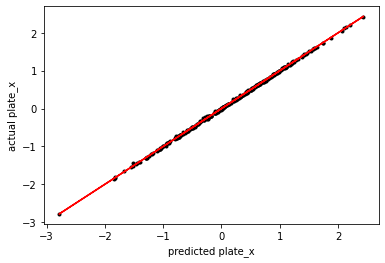

In [ ]:
plt.plot(model1.predict(testx), testy, 'k.')
plt.plot(model1.predict(testx), model1.predict(testx), 'r-')
plt.xlabel('predicted plate_x')
plt.ylabel('actual plate_x')
plt.show()

In [ ]:
model1.coef_

array([ 1.83509302,  0.42284698, -0.83471552])

In [ ]:
#now model platez 
features2 = ['tunnel_z', 'pfx_z', 'release_pos_z']
trainx = train[features2].values 
trainy = train.plate_z.values 
testx = test[features2].values 
testy = test.plate_z.values

model2 = LinearRegression().fit(trainx, trainy)

train_acc = np.sqrt(mean_squared_error(trainy, model2.predict(trainx)))
test_acc = np.sqrt(mean_squared_error(testy, model2.predict(testx)))

train_r2 = r2_score(trainy, model2.predict(trainx))
test_r2 = r2_score(testy, model2.predict(testx))

In [ ]:
train_r2, test_r2

(0.9789966275251516, 0.9844094817072103)

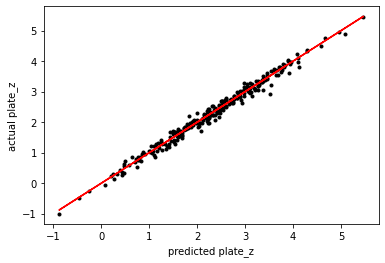

In [ ]:
plt.plot(model2.predict(testx), testy, 'k.')
plt.plot(model2.predict(testx), model2.predict(testx), 'r-')
plt.xlabel('predicted plate_z')
plt.ylabel('actual plate_z')
plt.show()

In [ ]:
model2.coef_

array([ 1.8030893 ,  0.58032815, -0.8119065 ])

In [ ]:
#save models 
import pickle
with open('/drive/My Drive/Colab Notebooks/sequencing_project/plate_x_model.pkl', 'wb') as f:
  pickle.dump(model1, f)

In [ ]:
with open('/drive/My Drive/Colab Notebooks/sequencing_project/plate_z_model.pkl', 'wb') as f:
  pickle.dump(model2, f)